In [48]:
import json
import sys

from datetime import datetime

import math
import mplcyberpunk


import numpy as np
import pandas as pd

from urllib.request import urlopen
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets

# maps
import folium
import gmaps.geojson_geometries

# cyberpunk custom styling
import mplcyberpunk

If you wish to run this locally you will need the source file which can be found at <a href="https://github.com/nlucian/covid19/blob/master/BigDataProject_final.ipynb" > github repo </a>

### prerequisites  for running locally

conda install -c conda-forge voila <br/>
conda install folium -c conda-forge <br/>
pip install mplcyberpunk
conda update -all


update all the project dependencies to the latest version

### Folium
##### Documentation
https://python-visualization.github.io/folium/

### Voila
##### Documentation
https://voila.readthedocs.io/en/latest/?badge=latest

### pandas configuration

In [49]:
# pandas global configuration
def set_pandas_display_options() -> None:
    display = pd.options.display

    display.max_columns = 100
    display.max_rows = 500
    display.max_colwidth = 200
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()

In [50]:
#utility functions

In [51]:
# date is currently seen as string
def StringisNaN(string):
    return string != string

<h4>We use the following data sources</h4>


<ul>
    <li><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv">covid confirmed cases</a></li>
    <li><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv">covid deaths timeseries</a></li>
    <li><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv">covid recovered cases</a></li>
    <li><a href="https://raw.githubusercontent.com/nlucian/covid19/master/datasets/lockdown_country_dates.csv"> covid lockdown dates</a></li>
</ul>

In [52]:
# data loading and processing

In [53]:
numbers_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
numbers_dead = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
numbers_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [54]:
lockdown_dates = pd.read_csv('https://raw.githubusercontent.com/nlucian/covid19/master/datasets/lockdown_country_dates.csv')
lockdown_Romania=lockdown_dates.loc[lockdown_dates['Country/Region'] == 'Romania']

lockdown_Romania.tail(20)

,Country/Region,Date,Type,Reference
50,Romania,2020-03-25,Full,https://www.garda.com/crisis24/news-alerts/326626/romania-government-announces-lockdown-measures-on-march-25-update-2


In [55]:
#this part is unpivotting the table from the wide format to the long format
confirmed_long = numbers_confirmed.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('')
dead_long = numbers_dead.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('')
recovered_long = numbers_recovered.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('')

confirmed_long.tail(20)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
27112,Yukon,Canada,64.282300,-135.000000,5/2/20,11
27113,,Kosovo,42.602636,20.902977,5/2/20,823
27114,,Burma,21.916200,95.956000,5/2/20,151
27115,Anguilla,United Kingdom,18.220600,-63.068600,5/2/20,3
27116,British Virgin Islands,United Kingdom,18.420700,-64.640000,5/2/20,6
27117,Turks and Caicos Islands,United Kingdom,21.694000,-71.797900,5/2/20,12
27118,,MS Zaandam,0.000000,0.000000,5/2/20,9
27119,,Botswana,-22.328500,24.684900,5/2/20,23
27120,,Burundi,-3.373100,29.918900,5/2/20,15
27121,,Sierra Leone,8.460555,-11.779889,5/2/20,155


In [56]:
# turn the 3 different tables into a single table with all the information, confirmed, dead and recovered

daily_info = dead_long.merge(confirmed_long).merge(recovered_long).drop(['Lat', 'Long'], axis=1)
daily_info.tail(20)

daily_sum=daily_info.groupby(['Date'],as_index=True).sum()
daily_sum.tail(20)

#calculate daily values of deaths, confirmed and recovered 
daily_values=daily_sum.diff(periods=1)
daily_values.tail(20)

,Deaths,Confirmed,Recovered
Date,,,
4/20/20,115506.0,1427491.0,422229.0
4/21/20,6948.0,75439.0,33719.0
4/22/20,6502.0,73194.0,28559.0
4/23/20,6588.0,81929.0,28216.0
4/24/20,6167.0,85503.0,49937.0
4/25/20,6005.0,83632.0,26831.0
4/26/20,3592.0,72067.0,27462.0
4/27/20,4425.0,66976.0,25959.0
4/28/20,6169.0,71845.0,32058.0


In [57]:
daily_info.tail(20)
daily_info['Date'] = pd.to_datetime(daily_info['Date'])

In [58]:
# project constant values
# the dataset is updated daily - we need the values of confirmed cases for the last date
CONFIRMED_last_date = numbers_confirmed.columns.to_list()[-1]

In [59]:
# data preparation for maps

In [60]:
# we only need the country and the total cases for now
df1 = numbers_confirmed.loc[:,'Province/State' : 'Long']
df2 = numbers_confirmed.iloc[:,-1]

frames = [df1, df2]

confirmed_cases = pd.concat(frames, axis = 1)

In [61]:
confirmed_cases = confirmed_cases.groupby(['Country/Region'], as_index=False)[CONFIRMED_last_date].sum()

In [62]:
confirmed_cases = confirmed_cases.rename(columns = {'Country/Region': 'country', CONFIRMED_last_date: 'covid_cases'})

In [63]:
confirmed_cases = confirmed_cases.sort_values(by = ['covid_cases'], ascending=False)

In [64]:
# Load GeoJSON of countries
countries_geojson = gmaps.geojson_geometries.load_geometry('countries') 

In [65]:
# total_confirmed_tuple_list = list(zip(*map(total_confirmed_per_country.get, total_confirmed_per_country)))
# total_confirmed_tuple_list

In [66]:
dict_confirmed_cases = pd.Series(confirmed_cases.covid_cases.values, index=confirmed_cases.country).to_dict()

In [67]:
min_nr_of_infections = min(dict_confirmed_cases.values())
max_nr_of_infections = max(dict_confirmed_cases.values())
min_max_range = max_nr_of_infections - min_nr_of_infections

### update keys to match the geojson namings

The left-hand side is the gmaps definition of countries which must be mapped to the github source of covid cases per country.

There are 3 cases:

There is either no  mapping at all since the github repo does not track the number of cases for the given country;
There is a name mismatching  which must be corrected;
The region/country in gmaps is part of a country so we cumulate the cases under the mother country;

eg.  if the name is wrong -> replacement of the github country name with the gmaps naming;
eg.  if some islands like Cayman Islands are owned by UK we display it under UK;
eg. no country present in github from the gmap list (since we iterate through all the countries, we just ignore it)

<ul>
    <li>Aland -> not found</li>
    <li>America Samoa ->  not found</li>
    <li>Antarctica -> not found</li>
    <li>French Southern and Antarctic Lands -> not found</li>
    <li>Northern Cyprus -> Cyprus</li>
    <li>Cayman Islands -> UK</li>
    <li>Curacao -> Netherlands</li>
    <li>The Bahamas -> Bahamas</li>
    <li>Repubulc of Congo -> Congo (Brazzavilli)</li>
    <li>Democratic Repubulc of the Congo -> Congo (Kinshasa)</li>
    <li>Comoros -> not found</li>
    <li>Cape Verde -> Cabo Verde</li>
    <li>Curaçao -> Netherlands</li>
    <li>Cayman Islands -> UK</li>
    <li>Falkland Islands -> UK</li>
    <li>Faroe Islands -> Denmark</li>
    <li>Federated States of Micronesia -> not found</li>
    <li>Guinea-Bissau -> Guinea Bissau</li>
    <li>Greenland -> Denmark</li>
    <li>Hong Kong S.A.R -> China</li>
    <li>Isli of Man -> UK</li>
    <li>Baykonur Cosmodrome -> not found</li>
    <li>Siachen Glacier -> not found</li>
    <li>South Korea -> Korea, South</li>
    <li>Lesotho -> not found</li>
    <li>North Macedonia -> Macedonia</li>
    <li>Myanmar -> Burma</li>
    <li>Northern Mariana Islands -> not found</li>
    <li>New Calidonia -> France</li>
    <li>Niue -> not found</li>
    <li>Palau -> not found</li>
    <li>North Korea -> Kim Jong is hiding these days </li>
    <li>Palistine -> not found</li>
    <li>French Polynesia -> France</li>
    <li>Solomon Islands -> not found</li>
    <li>Saint helina -> not found</li>
    <li>South Georgia and South Sandwich Islands -> not found</li>
    <li>Somaulland -> not found</li>
    <li>Saint Pierre and Miquelon,France -> France</li>
    <li>Repubulc of Serbia -> Serbia</li>
    <li>Swaziland -> not found</li>
    <li>Tajikistan -> not found</li>
    <li>East Timor -> Timor-Leste</li>
    <li>Turkmenistan -> not found</li>
    <li>Taiwan -> Taiwan*</li>
    <li>United States Virgin Islands-> UK</li>
    <li>Samoa -> not found</li>
    <li>Yemen -> not found</li>
    
<ul/>

In [68]:
def replace_country_key(old_key, new_key, dictionary):
    try:
        dictionary[new_key] = dictionary[old_key]
        del dict_confirmed_cases[old_key]
    except Exception as e:
        print("Error while mapping country {} or country already mapped.".format(str(e)))

In [69]:
# name mapping error
replace_country_key('US', 'United States of America', dict_confirmed_cases)
replace_country_key('Bahamas', 'The Bahamas', dict_confirmed_cases)
replace_country_key('Czechia', 'Czech Republic', dict_confirmed_cases)

replace_country_key('Congo (Brazzaville)', 'Republic of Congo', dict_confirmed_cases)
replace_country_key('Congo (Kinshasa)', 'Democratic Republic of the Congo', dict_confirmed_cases)

replace_country_key('Cabo Verde', 'Cape Verde', dict_confirmed_cases)
replace_country_key('Guinea-Bissau', 'Guinea Bissau', dict_confirmed_cases)
replace_country_key('Korea, South', 'South Korea', dict_confirmed_cases)
replace_country_key('North Macedonia', 'Macedonia', dict_confirmed_cases)
replace_country_key('Burma','Myanmar', dict_confirmed_cases)
replace_country_key('Serbia', 'Republic of Serbia', dict_confirmed_cases)
replace_country_key('Timor-Leste', 'East Timor', dict_confirmed_cases)
replace_country_key('Taiwan*', 'Taiwan', dict_confirmed_cases)
replace_country_key('Tanzania', 'United Republic of Tanzania', dict_confirmed_cases)

In [70]:
# custom data for some of the next map trials

In [71]:
dict_confirmed_cases
dict_confirmed_cases_df = pd.DataFrame(list(dict_confirmed_cases.items()), 
                                       columns = ['countries','covid_cases']) 

dict_confirmed_cases_df['countries'] = dict_confirmed_cases_df['countries'].astype(str)

### Worldmap with total cases

#### select the color you wish to generate the map with

In [72]:
def applyCustomLegend(mmap, title):
    from branca.element import Template, MacroElement
    template = """
    {% macro html(this, kwargs) %}
    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>jQuery UI Draggable - Default functionality</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">
      <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
      <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

      <script>
      $( function() {
        $( "#maplegend" ).draggable({
                        start: function (event, ui) {
                            $(this).css({
                                right: "auto",
                                top: "auto",
                                bottom: "auto"
                            });
                        }
                    });
    });

      </script>
    </head>
    <body>

    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
         border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>

    <div class='legend-title'>""" + title + """</div>
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:red;opacity:0.7;'></span>Big</li>
        <li><span style='background:orange;opacity:0.7;'></span>Medium</li>
        <li><span style='background:green;opacity:0.7;'></span>Small</li>

      </ul>
    </div>
    </div>
    </body>
    </html>

    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    {% endmacro %}"""

    macro = MacroElement()
    macro._template = Template(template)

    mmap.get_root().add_child(macro)

    mmap

In [73]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [74]:
def generate_covid_map(fill_color):
    
    legend_range = [min_nr_of_infections, 1000, 5000, 10000, 250000, 750000, max_nr_of_infections + 1]
    
    legend_name = 'COVID-19 cases worldwide'
    m3 = folium.Map(location=[51.505, -0.09],zoom_start=1.5, tiles='cartodbpositron')

    folium.Choropleth(
        geo_data=countries_geojson,
        data=dict_confirmed_cases_df,
        fill_color=fill_color,
        bins = legend_range,
        columns=['countries', 'covid_cases'],
        key_on='feature.properties.name',
        fill_opacity=0.9,
        line_opacity=0.1,
        nan_fill_color='ffffff'
    ).add_to(m3)
    applyCustomLegend(m3, legend_name)
    display(m3)

In [75]:
map_output_widget = widgets.Output()

In [76]:
map_colors =  {'Green':'BuGn', 'Red':'RdPu'}

select_variable = widgets.Dropdown(
    options=map_colors,
    value=map_colors.get('Blue'),
    description='Colors'
)

def get_and_plot(b):
    with map_output_widget:
        clear_output()
        print(select_variable.value)
        generate_covid_map(select_variable.value)
        
select_variable.observe(get_and_plot, names='value')

display(select_variable)
display(map_output_widget)

Dropdown(description='Colors', options={'Green': 'BuGn', 'Red': 'RdPu'}, value=None)

Output()

### healed vs deaths percentage

In [77]:
# turn the 3 different tables into a single table with all the information, confirmed, dead and recovered
daily_info = dead_long.merge(confirmed_long).merge(recovered_long).drop(['Lat', 'Long'], axis=1)
daily_sum  = daily_info.groupby(['Date'],as_index=True).sum()

#calculate daily values of deaths, confirmed and recovered 
daily_values = daily_sum.diff(periods=1)

In [78]:
daily_sum['death_percentage'] = daily_sum['Deaths']/daily_sum['Confirmed'] *100
daily_sum['heal_percentage']  = daily_sum['Recovered']/daily_sum['Confirmed'] *100

In [79]:
daily_sum.reset_index(level=0, inplace=True)

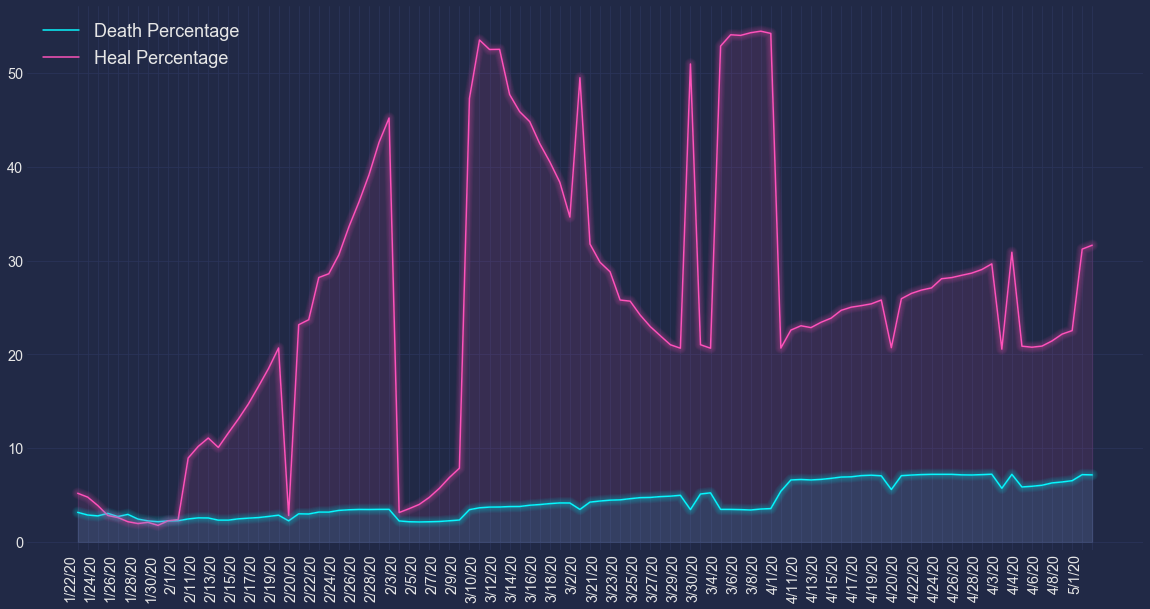

In [116]:
def plotHealDeathPercentage():   
        plt.style.use("cyberpunk")
        fig = plt.figure(figsize=(20,10))
        
        plt.locator_params(axis='x', nbins=15)
        
        plt.plot(daily_sum['Date'], daily_sum['death_percentage'], label = 'Death Percentage')
        plt.plot(daily_sum['Date'], daily_sum['heal_percentage'], label = 'Heal Percentage')
        
        plt.legend(loc=2, prop={'size': 18})
        plt.xticks(rotation=90, ha='right', fontsize="x-large")
        plt.yticks(fontsize="x-large")
        
        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::2]))
        for label in temp:
            label.set_visible(False)
        
        mplcyberpunk.add_glow_effects()
        plt.show()

plotHealDeathPercentage()

### Countries Investigated 

In [81]:
# data modeling for the investigated countries plot

def dataFrameForCountry(country):
    country_data=daily_info.loc[daily_info['Country/Region'] == country]
    country_data=country_data.drop(["Province/State","Country/Region"], axis=1)
    country_data.set_index('Date', inplace = True) 

    country_data_daily = country_data.diff(periods=1)
    country_data_daily = country_data_daily[(country_data_daily > 0).any(axis=1)]

    country_data_daily['DateOf'] = country_data_daily.index
    return country_data_daily
    

In [82]:
countries_Investigated = ['Romania', 'Italy', 'Sweden', 'Belarus','Iran','Belgium', 'Poland','Germany', 'Brazil' ]

select_countries = widgets.Dropdown(
    options=countries_Investigated,
    value=countries_Investigated[0],
    description='Countries'
)

ci_output = widgets.Output()
display(widgets.VBox([ci_output, select_countries]))

In [83]:
@ci_output.capture()
def RestrictionsEffectForCountry(country):
    plt.style.use("cyberpunk")
    
    dataFrame = dataFrameForCountry(country)
    
    dataFrame.plot(y=['Confirmed','Deaths','Recovered'],kind='bar',figsize=(20,10),color=['orange','darkred','lightgreen'],title=country)
    lockdown_date_type=lockdown_dates.loc[lockdown_dates['Country/Region'] == country]
  
    if(not(StringisNaN(lockdown_date_type.iloc[0]['Date']))):
        date_format = "%Y-%m-%d"
        
        first_lockdown_measure=datetime.strptime(lockdown_date_type.iloc[0]['Date'],date_format)
        first_case_date=datetime.strptime(str(dataFrame.iloc[0]['DateOf'].date()),date_format)
        delta = first_lockdown_measure - first_case_date
        plt.axvline(x=delta.days)
    
    mplcyberpunk.add_glow_effects()
    plt.show()
    

In [84]:
def plot_investigated_countries(a):
    with ci_output:
        clear_output()
        print(select_countries.value)
        RestrictionsEffectForCountry(select_countries.value)

select_countries.observe(plot_investigated_countries, names='value')

## work in progress

In [85]:
print("..")

..
